In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math

# red image on the left
# cyan image on the right


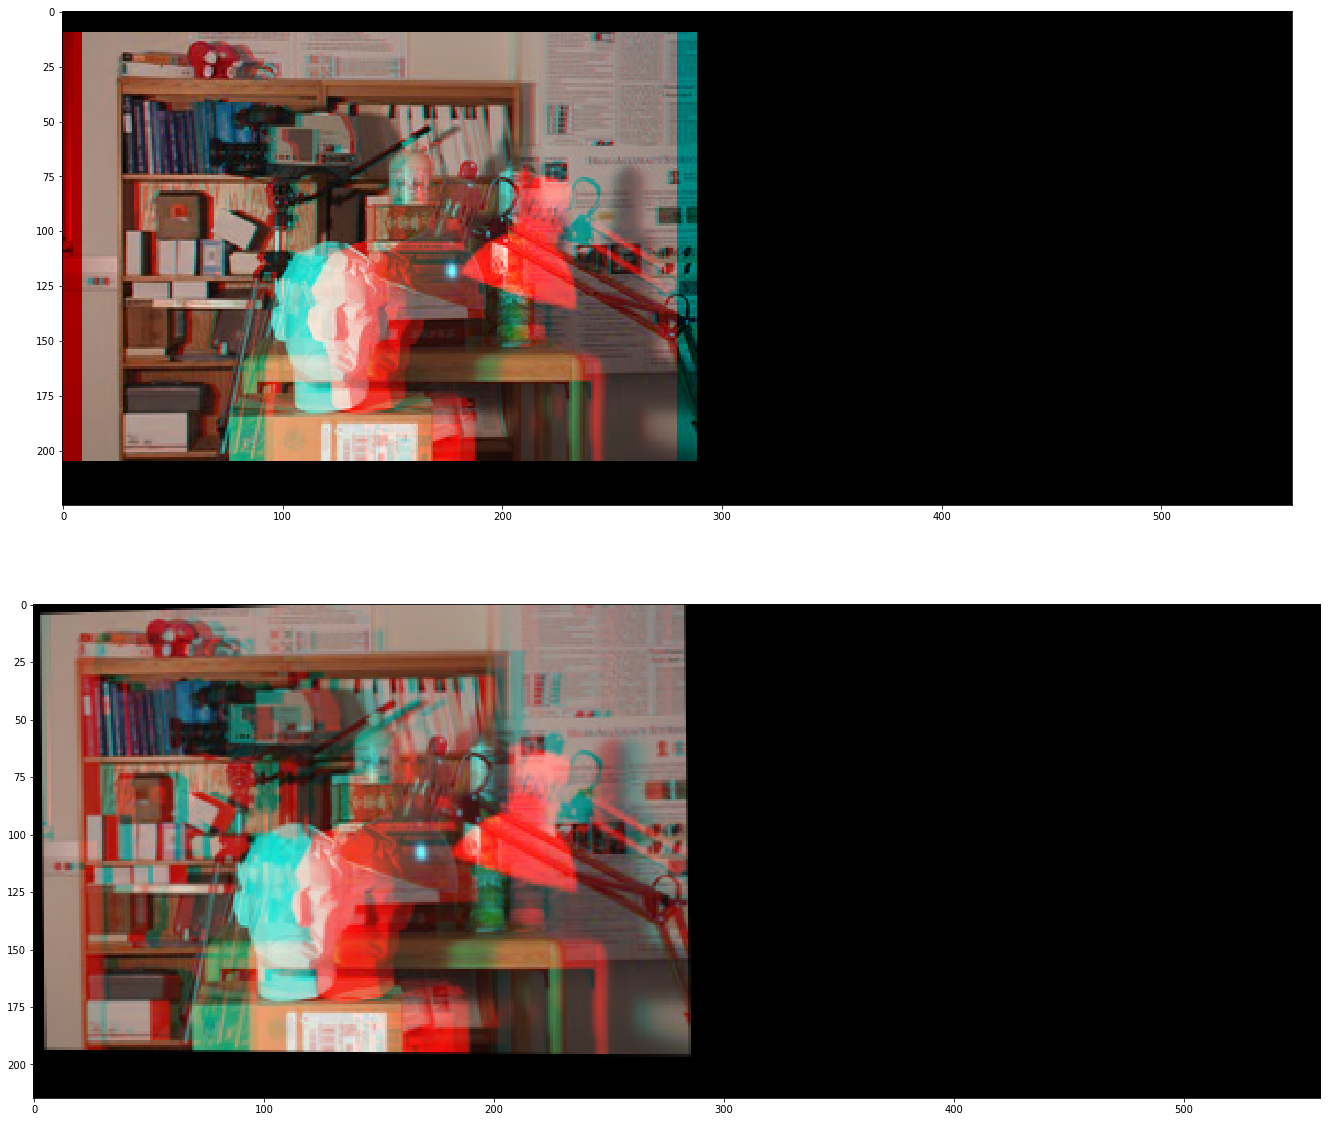

In [154]:
image0 = cv2.imread("images/newkuba/im0.jpg")
image1 = cv2.imread("images/newkuba/im1.jpg")

class Stitcher:
    def __init__(self):
        pass
    
    def detectAndDescribe(self, image):
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        sift = cv2.xfeatures2d.SIFT_create()
        (kps, features) = sift.detectAndCompute(image, None)
        kps = np.float32([kp.pt for kp in kps])
        
        return (kps, features)
    
    def matchKeypoints(self, kpsA, kpsB, featuresA, featuresB, ratio, reprojThres):
        bf = cv2.BFMatcher(crossCheck=True)
        matches = bf.match(featuresA, featuresB)
        matches.sort(key=lambda x: x.distance)
        matches = matches[:10]
        if len(matches) > 4:
            ptsA = np.float32([kpsA[m.queryIdx] for m in matches])
            ptsB = np.float32([kpsB[m.trainIdx] for m in matches])
#             ptsA = np.float32([kpsA[i] for (_, i) in matches])
            (F, _) = cv2.findFundamentalMat(ptsA, ptsB, method=cv2.FM_8POINT)
            featuresA1 = ptsA.reshape(ptsA.shape[0] * 2, 1)
            featuresB1 = ptsB.reshape(ptsB.shape[0] * 2, 1)
            (_, H1, H2) = cv2.stereoRectifyUncalibrated(featuresA1, featuresB1, F, imgSize=(280,195))
            
            (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC, reprojThres)
            
            # return the matches along with the homography matrix
            # and status of each matched point
            return (matches, H, H1, H2, status)
        
        # otherwise, no homography could be computed
        return None
    
    def stitch(self, images, ratio=0.75, reprojThres=4.0, showMatches=False):
        # unpack the images, then detect keypoints and extract
        # local invariant descriptors from them
        (imageA, imageB) = images
        (kpsA, featuresA) = self.detectAndDescribe(imageA)
        (kpsB, featuresB) = self.detectAndDescribe(imageB)
        
        # match features between the two images
        M = self.matchKeypoints(kpsA, kpsB, featuresA, featuresB, ratio, reprojThres)
#         ptsB = np.float32([kpsB[i] for (i, _) in matches])
        
        if M is None:
            return None
        
#         (matches, H, status) = M
        # otherwise, apply a perspective warp to stitch the images
        # together
        (matches, H, H1, H2, status) = M
        #perspective warp for H1,H2
        
        stereo = np.zeros((imageA.shape[0] + 20, imageA.shape[1] * 2))
        stereo = cv2.warpPerspective(imageA, H2, (stereo.shape[1], stereo.shape[0]))
        (_, _, r) = cv2.split(stereo)
        stereo = cv2.warpPerspective(imageB, H2, (stereo.shape[1], stereo.shape[0]))
        (b, g, _) = cv2.split(stereo)
        stereo = cv2.merge([r, g, b])
        
        
        # only use rotation and translation of H
        H[2] = [0, 0, 1]
        (_, _, r) = cv2.split(imageA)
        (b, g, _) = cv2.split(imageB)
        imageA_corrected = cv2.merge([r, g, b])
        (rowsA, colsA, _) = imageA.shape
        (rowsB, colsB, _) = imageB.shape
#         result = np.copy(imageA)
#         result = imageA_corrected
#         print(imageA.shape)
       
#         result = cv2.warpPerspective(imageA_corrected, H,
#             (imageA.shape[1] + imageB.shape[1], imageA.shape[0] + 20))
#         print(result.shape)
#         print(imageA.shape)
#         print(result.shape)
#         result[0:imageA.shape[0], 0:imageA.shape[1]][2] = imageA[2]
#         result[0:imageB.shape[0], 0:imageB.shape[1], 1] = g1
#         result[0:imageB.shape[0], 0:imageB.shape[2], 2] = b1
#         result[0:imageB.shape[0], 0:imageB.shape[1], 0] = r1
        y_offset = 1.99239960e+00
        x_offset = 8.43412440e+00
        x_offset = 9
        y_offset = 2
        result = np.zeros((imageA.shape[0] + 30, 2 * imageA.shape[1], 3), dtype=np.int)
        result2 = np.copy(result)
        result[10:imageA.shape[0] + 10, 0:imageA.shape[1], 0] = r
        result[10:imageA.shape[0] + 10, imageB.shape[1]:imageB.shape[1]+imageB.shape[1], 2] = b
        result[10:imageA.shape[0] + 10, imageB.shape[1]:imageB.shape[1]+imageB.shape[1], 1] = g
        
        result2[10:imageA.shape[0] + 10, 0:imageA.shape[1], 0] = r
        result2[10:imageA.shape[0] + 10, 0 + x_offset:imageB.shape[1] + x_offset, 2] = b
        result2[10:imageA.shape[0] + 10, 0 + x_offset:imageB.shape[1] + x_offset, 1] = g
        
        if showMatches:
            vis = self.drawMatches(imageA, imageB, kpsA, kpsB, matches, status)
            
            # return a tuple of the stitched image and the
            # visualiaztion
            return (result, vis)
        return result, result2, stereo
    
stitcher = Stitcher()
(result, result2, stereo) = stitcher.stitch([image0, image1])
# plt.figure(figsize=(40,20))
# plt.imshow(result)
fig, ax = plt.subplots(2,1)
fig.set_size_inches(40,20, forward=True)
ax[0].imshow(result2)
ax[1].imshow(stereo)

    

        